In [28]:
import autograd.numpy as np
from autograd import grad
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from sklearn.decomposition import FactorAnalysis, PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LogisticRegression


In [260]:
#build toy dataset
def generate_samples_3d(n_samples_class):
    cov = np.array([[10, 2, 2], [2, 10, 2], [2, 2, 2]])
    mean1 = np.array([0, 0, 0])
    mean2 = np.array([0, 0, 3])

    total_n_samples = n_samples_class*2
    x =  np.zeros((total_n_samples, 3))

    x[:n_samples_class, 0], x[:n_samples_class, 1], x[:n_samples_class, 2] = np.random.multivariate_normal(mean1, cov, n_samples_class).T
    x[n_samples_class:, 0], x[n_samples_class:, 1], x[n_samples_class:, 2]  = np.random.multivariate_normal(mean2, cov, n_samples_class).T

    labels = np.zeros(total_n_samples)
    labels[n_samples_class:] = 1
    return x, labels

Text(0.5,0,'Z Label')

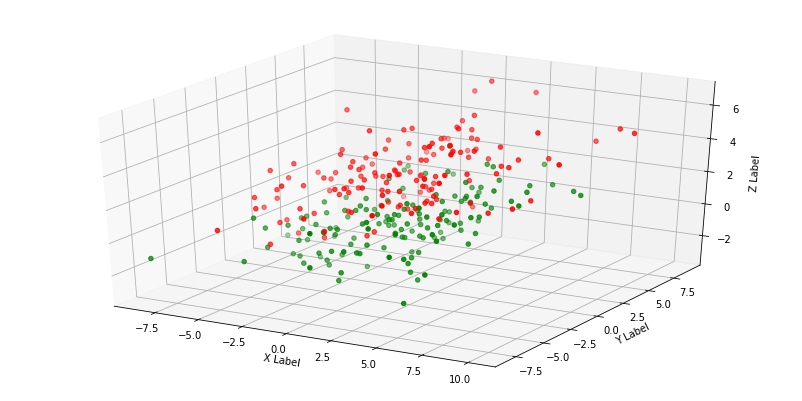

In [261]:
n_samples_class = 150
x, y  =  generate_samples_3d(n_samples_class)
fig = plt.figure(figsize=(14,7))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:n_samples_class,0], x[:n_samples_class,1],x[:n_samples_class,2], color = 'g')
ax.scatter(x[n_samples_class:,0], x[n_samples_class:,1],x[n_samples_class:,2], color = 'r')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')


In [262]:
latent_dim = 2 #suppose z is scalar
x_dim = 3      
params_size_logit_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim + 1
params_size_norm_fa = x_dim*latent_dim + x_dim + x_dim + latent_dim
params_size_logit_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
params_size_norm_ppca = x_dim*latent_dim + x_dim + 1 + latent_dim 

In [263]:
params_size_logit_ppca

13

In [264]:
opt = "ppca"

if (opt == "fa"):
    params_size = params_size_logit_fa
else:
    params_size = params_size_logit_ppca
    


In [265]:
transformer = PCA(n_components=latent_dim)
#transformer = FactorAnalysis(n_components=1, random_state=0)
x_proj_sklearn = transformer.fit_transform(x)

f_sklearn = transformer.components_.T
cov_noise_sklearn = np.diag(np.ones(x_dim)*transformer.noise_variance_)
bias_sklearn = np.mean(x, axis =0)



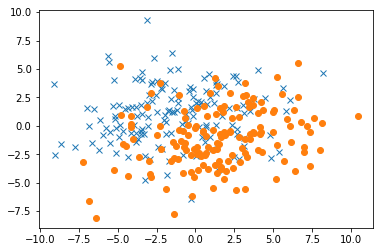

In [254]:
plt.plot(x_proj_sklearn[:n_samples_class,0], x_proj_sklearn[:n_samples_class,1], 'x')
plt.plot(x_proj_sklearn[n_samples_class:,0], x_proj_sklearn[n_samples_class:,1], 'o')

#plt.savefig('data_proj_fa_python')
plt.show()

In [ ]:
plt.plot(x_proj_sklearn[:n_samples_class,0], np.ones(n_samples_class), 'x')
plt.plot(x_proj_sklearn[n_samples_class:,0], np.zeros(n_samples_class), 'o')

#plt.savefig('data_proj_fa_python')
plt.show()

In [255]:
def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

compute_ll(f_sklearn, bias_sklearn, cov_noise_sklearn, x)

-2397.698041299366

In [180]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior
    return ll 


def objective_norm (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    sigma = 1 # variance for the noise in y
    N = x.shape[0]
    D = x.shape[1]
    f, bias, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    
    temp1 = np.einsum("dl,dm->lm", f, np.linalg.solve(cov_x,f)) #in fact m=l <- latent dimension 
    cov_z = np.identity(latent_dim) - temp1

    var_y = np.dot(w,np.dot(cov_z,w)) + sigma**2
    
    ll = N*D*np.log(2*np.pi)/2+(log_det_cov_x + lambda_e*np.log(var_y))*N*0.5
    
    temp2 = np.linalg.solve(cov_x, (x - bias).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias, temp2)
    mean_z = np.einsum("dl,dn->nl", f, temp2)
    mean_y = np.einsum("l,nl->n", w, mean_z)
    unnorm_log_pdf_y = (y - mean_y)**2/var_y
    ll = ll + 0.5*(np.sum(unnorm_log_pdf_x) + lambda_e*np.sum(unnorm_log_pdf_y))
    
    log_prior = 0 #f,bias,cov_noise and m for regularization use gaussian priors later
    ll = ll - log_prior
    return ll

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        #cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

In [256]:
params = np.random.rand(params_size)
f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]
print "initial obj value logit", objective_logit(params, x, y, latent_dim, 0, opt)
#print "initial obj value norm", objective_norm(params, x, y, latent_dim, 0, opt)

Initial parameters
F: [[0.06657978 0.11884726]
 [0.54173661 0.78908261]
 [0.91187017 0.53190904]]
slope [8.13665359 6.63946851]
bias:  [0.03916101 0.30667235 0.478828  ]
cov_noise matrix:  [[1.78344943 0.         0.        ]
 [0.         1.78344943 0.        ]
 [0.         0.         1.78344943]]
bias for y:
0.492830324376499
logistic regression weights:
[0.11521747 0.78813663]
initial obj value logit 2734.6191129117956


In [257]:
lambda_e = 10
#run minimizer use ADAM instead?
def pcallback(params):
    f, bias, cov_noise, w = decode_parameters(params, x_dim, latent_dim, opt)
    print compute_ll(f, bias, cov_noise, x), f[1]/f[0]

    
grad_objective_logit = grad(objective_logit, argnum = 0)

params_optimizied_logit, obj_value_logit, dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_e, opt), callback= pcallback, pgtol = 1e-2)
f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
print "Final parameters_logit"
print "logit slope\n", f_logit[1]/f_logit[0]
print "F:\n", f_logit
print "bias for x:\n", bias_logit
print "cov_noise matrix:\n", cov_noise_logit
print "bias for y:\n", w_logit[0]
print "logistic regression weights:\n", w_logit[1:]
print "final objective value:\n", obj_value_logit
dict

-2239.271819699464 [2.59299938 5.33156962]
-2196.513856707618 [2.0030517  7.05740288]
-2178.0197556539947 [ 1.13744438 -0.56120239]
-2196.55355528532 [-1.06853902  0.96550641]
-2203.996945138982 [-0.68745732  1.62831591]
-2205.804425469908 [-0.63831479  1.70389566]
-2198.093724368874 [-0.38058615  1.83147408]
-2162.948815793933 [0.08952955 1.42867553]
-2149.700856142385 [0.22953947 0.95308494]
-2145.686134717132 [0.25818856 0.88726707]
-2145.8689563812 [0.27022984 0.88013644]
-2146.583183180309 [0.25994639 0.93954108]
-2145.948089976358 [0.268622   0.91623185]
-2145.193976107852 [0.27612053 0.95198038]
-2144.640037383125 [0.28769812 1.00593686]
-2144.716922214541 [0.31346759 1.09616638]
-2144.4532205699647 [0.32454485 1.10487268]
-2144.267066285985 [0.33915669 1.09860339]
-2144.2301711532273 [0.33782159 1.09439774]
-2144.1229454563027 [0.32758058 1.07251871]
-2144.0871924281764 [0.32430825 1.04633106]
-2143.9918277549077 [0.31546451 1.00811695]
-2143.799909981921 [0.29811591 0.93990947

-2142.276092898779 [0.40588339 0.47722983]
-2142.27547014034 [0.40507053 0.47542756]
-2142.2746937298834 [0.40390762 0.47323812]
-2142.274964587058 [0.4034403  0.47310135]
-2142.2747965726307 [0.40289141 0.47204531]
-2142.27479224746 [0.40299774 0.47221304]
-2142.2747752065707 [0.40285161 0.47195491]
-2142.274724963546 [0.40268256 0.47159337]
-2142.2744725855123 [0.40239016 0.4705696 ]
-2142.2737918428325 [0.40218752 0.46885558]
-2142.2732391697436 [0.40272057 0.46860396]
-2142.2729351691423 [0.4029137  0.46819458]
-2142.272599257487 [0.40395525 0.46859107]
-2142.272508226588 [0.4040531  0.46863621]
-2142.2723194229065 [0.40423348 0.46851486]
-2142.2718733300085 [0.40460423 0.46825796]
-2142.271451555878 [0.40488673 0.46785993]
-2142.2706278990554 [0.40527892 0.46713762]
-2142.2696172756796 [0.40581928 0.46633309]
-2142.2697852250444 [0.40555867 0.46631074]
-2142.2693951373894 [0.40589812 0.46604834]
-2142.268864353192 [0.40655068 0.46602376]
-2142.2689805737177 [0.40657003 0.46625012]

{'funcalls': 323,
 'grad': array([-0.15387624, -0.21635695,  0.05757864, -0.20565073,  0.03981775,
         0.35490954,  0.11020397, -0.07308911,  0.06273542,  0.13440133,
         0.16804767,  0.00296152, -0.00151005]),
 'nit': 269,
 'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
 'warnflag': 0}

In [226]:
print "F sklearn", f_sklearn 
print "mean of x \n", bias_sklearn 
print "cov noise sklearn\n", cov_noise_sklearn 
#print transformer.loglike_

F sklearn [[ 0.01448352 -0.84159255]
 [-0.00203342  0.53994943]
 [ 0.99989304  0.01328858]]
mean of x 
[0.09078302 0.15267871 1.71238349]
cov noise sklearn
[[2.84768083 0.         0.        ]
 [0.         2.84768083 0.        ]
 [0.         0.         2.84768083]]


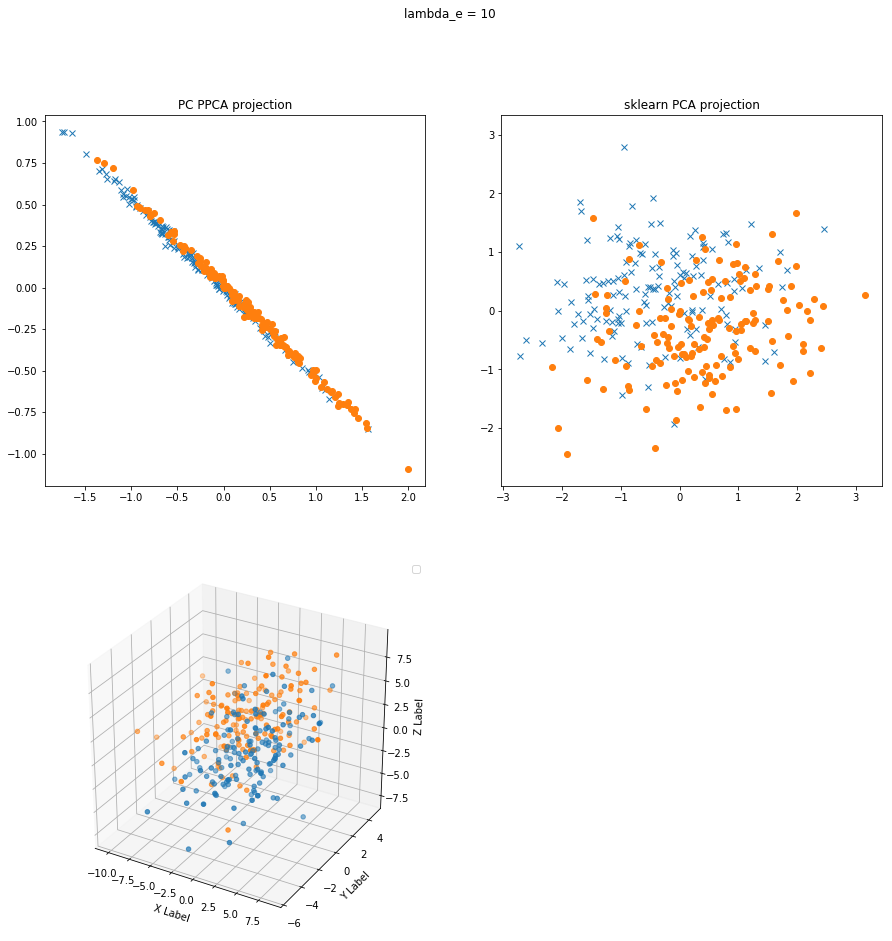

In [258]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(221)

#plt.axis('equal')

plt.suptitle("lambda_e = {}".format(lambda_e))

plt.title("PC PPCA projection")
x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
plt.plot(x_proj_logit[:n_samples_class, 0], x_proj_logit[:n_samples_class, 1], 'x')
plt.plot(x_proj_logit[n_samples_class:, 0], x_proj_logit[n_samples_class:, 1], 'o')

fig.add_subplot(222) 
plt.axis('equal')

plt.title("sklearn PCA projection")
x_trans_sklearn = transform(f_sklearn, bias_sklearn, cov_noise_sklearn, x)
plt.plot(x_trans_sklearn[:n_samples_class,0], x_trans_sklearn[:n_samples_class,1], 'x')
plt.plot(x_trans_sklearn[n_samples_class:,0], x_trans_sklearn[n_samples_class:,1], 'o')


ax = fig.add_subplot(223, projection='3d')
ax.scatter(x[:n_samples_class,0], x[:n_samples_class,1],x[:n_samples_class,2])
ax.scatter(x[n_samples_class:,0], x[n_samples_class:,1],x[n_samples_class:,2])

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

#plt.plot(a_pc_fa_logit, b_pc_fa_logit,  color ="g", label='pc ppca')
#plt.plot(a_sklearn, b_sklearn, color ="b", label='sklearn pca')

plt.legend()

plt.savefig("data_lambda_e={}_logistic_pc_ppca_vs_sklearn_pca.png".format(lambda_e))
plt.show()

In [259]:
clf_sklearn = LogisticRegression().fit(x_trans_sklearn, y)
print clf_sklearn.score(x_trans_sklearn, y)

clf_pc = LogisticRegression().fit(x_proj_logit, y)
print clf_pc.score(x_proj_logit, y)

0.74
0.6866666666666666


In [232]:
clf = LogisticRegression().fit(x, y)
clf.score(x, y)

0.68

In [100]:
lambda_es = np.arange(2,3.5,0.1)
acc_scores = np.zeros(lambda_es.shape[0])
obj_values_logit = np.zeros(lambda_es.shape[0])
ll_logit = np.zeros(lambda_es.shape[0])
for i in range(lambda_es.shape[0]):
    params_optimizied_logit, obj_values_logit[i], dict = fmin_l_bfgs_b(objective_logit, x0 = params, fprime = grad_objective_logit, args = (x, y, latent_dim, lambda_es[i], opt), pgtol = 1e-2)
    f_logit, bias_logit, cov_noise_logit, w_logit = decode_parameters(params_optimizied_logit, x_dim, latent_dim, opt)
    x_proj_logit = transform(f_logit, bias_logit, cov_noise_logit, x)
    clf_pc = LogisticRegression().fit(x_proj_logit, y)
    acc_scores[i] = clf_pc.score(x_proj_logit, y)
    ll_logit[i] = compute_ll(f_logit, bias_logit, cov_noise_logit, x)

In [ ]:
lambda_es


In [ ]:
acc_scores[17]

In [ ]:
obj_values_logit[16]

In [ ]:
obj_values_logit[17]

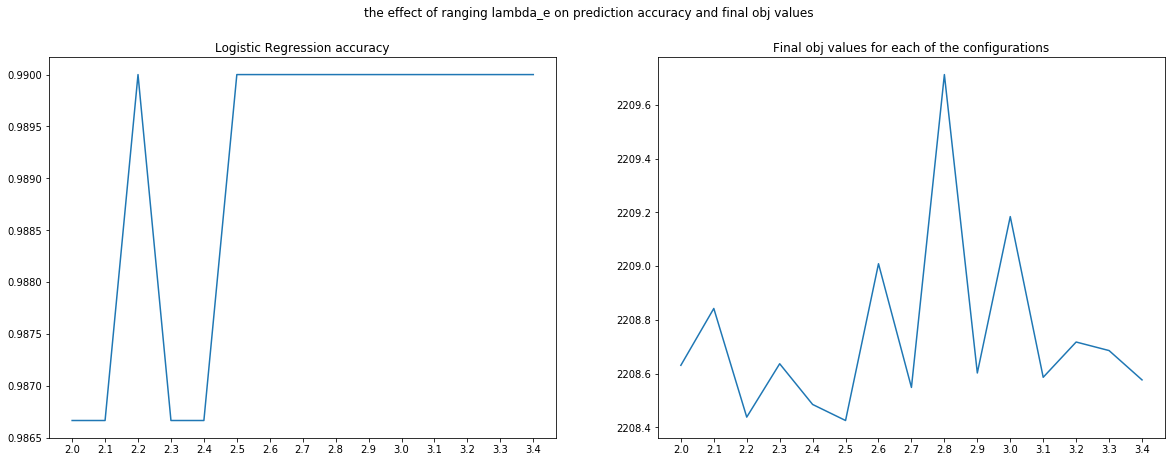

In [101]:
plt.figure(figsize=(20,7))
plt.subplot(121) 
plt.suptitle("the effect of ranging lambda_e on prediction accuracy and final obj values")
plt.title("Logistic Regression accuracy")
plt.xticks(lambda_es)
plt.plot(lambda_es, acc_scores)
plt.subplot(122) 
plt.title("Final obj values for each of the configurations")
plt.plot(lambda_es, obj_values_logit)
plt.xticks(lambda_es)
plt.savefig("lambda_e=[0,1]_pc_ppca.png".format(lambda_e))


In [ ]:
print objective_logit(params_optimizied_logit, x, y, latent_dim, 0.16, opt)
print obj_values_logit[17]
print obj_values_logit[16]

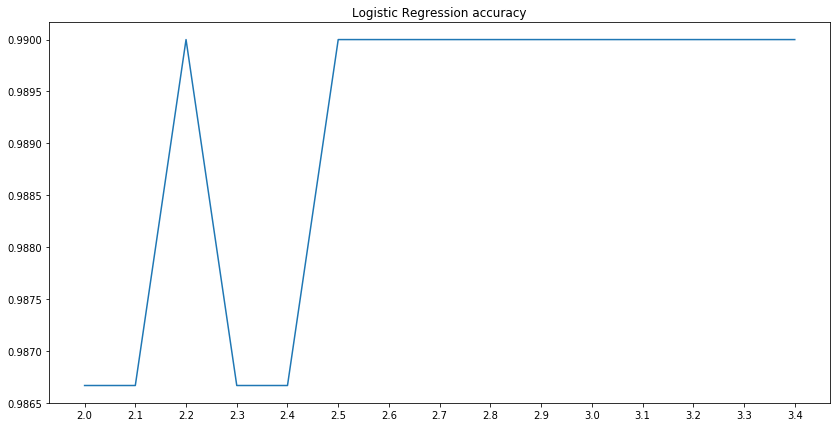

In [102]:
plt.figure(figsize=(14,7))
plt.title("Logistic Regression accuracy")
plt.xticks(lambda_es)
plt.plot(lambda_es, acc_scores)
plt.savefig("lambda_e=[0.16,0.17]_acc_pc_ppca.png".format(lambda_e))


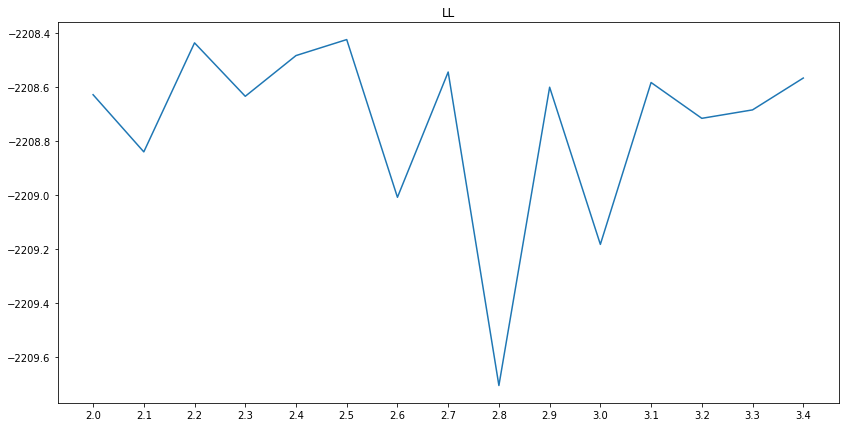

In [103]:
plt.figure(figsize=(14,7))
plt.title("LL")
plt.xticks(lambda_es)
plt.plot(lambda_es, ll_logit)
plt.savefig("lambda_e=[0.16,0.17]_ll_pc_ppca.png".format(lambda_e))


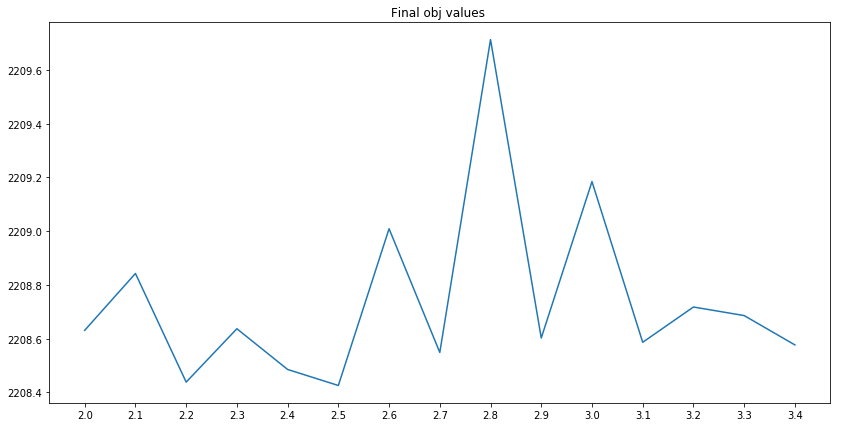

In [104]:
plt.figure(figsize=(14,7))
plt.title("Final obj values ")
plt.xticks(lambda_es)
plt.plot(lambda_es, obj_values_logit)
plt.savefig("lambda_e=[0.16,0.17]_obj_pc_ppca.png".format(lambda_e))

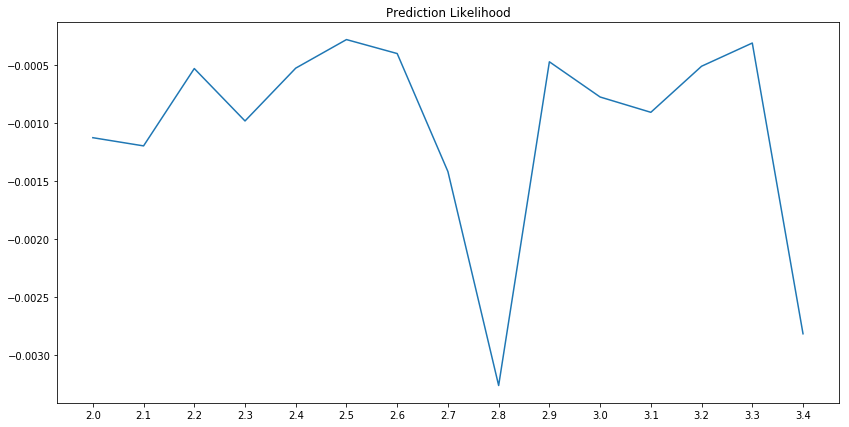

In [105]:
pred_l_logit = (-ll_logit - obj_values_logit)/lambda_es
plt.figure(figsize=(14,7))
plt.title("Prediction Likelihood")
plt.xticks(lambda_es)
plt.plot(lambda_es, pred_l_logit)
plt.savefig("lambda_e=[0.16,0.17]_pl_pc_ppca.png".format(lambda_e))